# Model Evaluation for Appliance Energy Prediction
# Comprehensive performance analysis and visualization


## 1. Imports and Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
import json
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10


## 2. Load Predictions

In [2]:
predictions_df = pd.read_csv('models/predictions/test_predictions.csv')
print(f"Predictions loaded: {len(predictions_df):,} samples")

# Load training metadata
with open('models/training_metadata.json', 'r') as f:
    metadata = json.load(f)

print("\nTraining Metadata:")
print(f"  Training date:    {metadata['training_date']}")
print(f"  Model type:       {metadata['model_type']}")
print(f"  Features:         {metadata['n_features']}")
print(f"  Best iteration:   {metadata['best_iteration']}")
print(f"  Used smoothing:   {metadata['used_smoothing']}")

# Preview predictions
print("\nPredictions preview:")
print(predictions_df.head())

Predictions loaded: 2,960 samples

Training Metadata:
  Training date:    2025-12-28 23:29:28
  Model type:       XGBoost Quantile Regression
  Features:         55
  Best iteration:   659
  Used smoothing:   False

Predictions preview:
                  date  actual  predicted_raw  predicted_smoothed  \
0  2016-05-07 04:30:00    60.0      59.238490           59.238490   
1  2016-05-07 04:40:00    60.0      56.763996           56.763996   
2  2016-05-07 04:50:00    50.0      57.204680           57.204680   
3  2016-05-07 05:00:00    50.0      58.962580           58.962580   
4  2016-05-07 05:10:00    50.0      54.336952           54.336952   

   final_prediction  
0         59.238490  
1         56.763996  
2         57.204680  
3         58.962580  
4         54.336952  


## 3. Extract Predictions and Actuals

In [3]:
y_true = predictions_df['actual'].values
y_pred_raw = predictions_df['predicted_raw'].values
y_pred_smoothed = predictions_df['predicted_smoothed'].values
y_pred_final = predictions_df['final_prediction'].values
dates = pd.to_datetime(predictions_df['date'])

print(f"Data shapes:")
print(f"  Actual:           {y_true.shape}")
print(f"  Predicted (raw):  {y_pred_raw.shape}")
print(f"  Predicted (final): {y_pred_final.shape}")

Data shapes:
  Actual:           (2960,)
  Predicted (raw):  (2960,)
  Predicted (final): (2960,)


## 4. Calculate Core Metrics

In [4]:
def calculate_metrics(y_true, y_pred, name="Model"):
    """Calculate all evaluation metrics"""
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100
    
    return {
        'name': name,
        'MAE': mae,
        'RMSE': rmse,
        'R2': r2,
        'MAPE': mape
    }

# %%
# Calculate metrics for all prediction types
metrics_raw = calculate_metrics(y_true, y_pred_raw, "Raw Predictions")
metrics_smoothed = calculate_metrics(y_true, y_pred_smoothed, "Smoothed Predictions")
metrics_final = calculate_metrics(y_true, y_pred_final, "Final Predictions")

# Create metrics comparison table
metrics_df = pd.DataFrame([metrics_raw, metrics_smoothed, metrics_final])

print("\n" + "="*80)
print("PERFORMANCE METRICS COMPARISON")
print("="*80)
print(f"\n{metrics_df.to_string(index=False)}")
print("\n" + "="*80)



PERFORMANCE METRICS COMPARISON

                name       MAE      RMSE       R2      MAPE
     Raw Predictions 26.926040 72.248892 0.368073 18.681294
Smoothed Predictions 27.083676 72.673160 0.360629 18.650661
   Final Predictions 26.926040 72.248892 0.368073 18.681294



## 5. Error Distribution Analysis
##### Analyze prediction errors across different ranges


In [5]:
# Calculate errors
errors = np.abs(y_true - y_pred_final)

print("\n" + "="*80)
print("ERROR DISTRIBUTION")
print("="*80)

# Define error ranges
ranges = [5, 10, 20, 30, 50, 100, 200]
print(f"\n{'Error Range':<15} {'Count':<10} {'Percentage':<12} {'Cumulative'}")
print("-" * 60)

cumsum = 0
for i, threshold in enumerate(ranges):
    if i == 0:
        count = (errors <= threshold).sum()
        label = f"0-{threshold}"
    else:
        count = ((errors > ranges[i-1]) & (errors <= threshold)).sum()
        label = f"{ranges[i-1]}-{threshold}"
    
    pct = count / len(errors) * 100
    cumsum += pct
    print(f"{label:<15} {count:<10} {pct:>10.2f}%    {cumsum:>10.2f}%")

# Large errors
count = (errors > ranges[-1]).sum()
pct = count / len(errors) * 100
cumsum += pct
print(f"{f'>{ranges[-1]}':<15} {count:<10} {pct:>10.2f}%    {cumsum:>10.2f}%")



ERROR DISTRIBUTION

Error Range     Count      Percentage   Cumulative
------------------------------------------------------------
0-5             998             33.72%         33.72%
5-10            704             23.78%         57.50%
10-20           601             20.30%         77.80%
20-30           201              6.79%         84.59%
30-50           163              5.51%         90.10%
50-100          117              3.95%         94.05%
100-200         79               2.67%         96.72%
>200            97               3.28%        100.00%


## 6. Accuracy by Tolerance
###### Percentage of predictions within acceptable error margins

In [6]:
print("\n" + "="*80)
print("ACCURACY BY TOLERANCE")
print("="*80)
print(f"\n{'Tolerance':<15} {'Within Count':<15} {'Percentage'}")
print("-" * 50)

tolerances = [5, 10, 15, 20, 30, 50, 100, 150, 200]
accuracy_results = []

for tol in tolerances:
    within = (errors <= tol).sum()
    pct = within / len(errors) * 100
    accuracy_results.append({'tolerance': tol, 'count': within, 'percentage': pct})
    print(f"±{tol:<14} {within:<15} {pct:>10.1f}%")

accuracy_df = pd.DataFrame(accuracy_results)



ACCURACY BY TOLERANCE

Tolerance       Within Count    Percentage
--------------------------------------------------
±5              998                   33.7%
±10             1702                  57.5%
±15             2087                  70.5%
±20             2303                  77.8%
±30             2504                  84.6%
±50             2667                  90.1%
±100            2784                  94.1%
±150            2836                  95.8%
±200            2863                  96.7%


## 7. Error Statistics Summary


In [7]:
print("\n" + "="*80)
print("ERROR STATISTICS")
print("="*80)
print(f"\nMean Error:       {errors.mean():.2f} Wh")
print(f"Median Error:     {np.median(errors):.2f} Wh")
print(f"Std Dev:          {errors.std():.2f} Wh")
print(f"Min Error:        {errors.min():.2f} Wh")
print(f"Max Error:        {errors.max():.2f} Wh")
print(f"25th Percentile:  {np.percentile(errors, 25):.2f} Wh")
print(f"75th Percentile:  {np.percentile(errors, 75):.2f} Wh")
print(f"95th Percentile:  {np.percentile(errors, 95):.2f} Wh")
print(f"99th Percentile:  {np.percentile(errors, 99):.2f} Wh")



ERROR STATISTICS

Mean Error:       26.93 Wh
Median Error:     8.18 Wh
Std Dev:          67.04 Wh
Min Error:        0.00 Wh
Max Error:        730.39 Wh
25th Percentile:  3.44 Wh
75th Percentile:  17.87 Wh
95th Percentile:  122.05 Wh
99th Percentile:  367.24 Wh


## 8. Performance by Usage Level

In [8]:
def analyze_by_usage_level(y_true, y_pred):
    """Analyze performance across usage levels"""
    errors = np.abs(y_true - y_pred)
    
    # Define usage levels
    levels = [
        (0, 100, "Low (0-100)"),
        (100, 200, "Medium (100-200)"),
        (200, 300, "High (200-300)"),
        (300, np.inf, "Very High (>300)")
    ]
    
    results = []
    for min_val, max_val, label in levels:
        mask = (y_true >= min_val) & (y_true < max_val)
        if mask.sum() > 0:
            level_errors = errors[mask]
            results.append({
                'Level': label,
                'Count': mask.sum(),
                'MAE': level_errors.mean(),
                'Median Error': np.median(level_errors),
                'Max Error': level_errors.max()
            })
    
    return pd.DataFrame(results)

# %%
usage_analysis = analyze_by_usage_level(y_true, y_pred_final)

print("\n" + "="*80)
print("PERFORMANCE BY USAGE LEVEL")
print("="*80)
print(f"\n{usage_analysis.to_string(index=False)}")



PERFORMANCE BY USAGE LEVEL

           Level  Count        MAE  Median Error  Max Error
     Low (0-100)   2155   9.070899      6.184640 149.177490
Medium (100-200)    549  25.521421     16.183160 208.236400
  High (200-300)    121  76.471983     70.513580 214.254300
Very High (>300)    135 273.251259    274.315315 730.391136


## 9. Performance by Time of Day
###### Analyze prediction accuracy across different hours


In [12]:
import numpy as np
import pandas as pd

def analyze_by_hour(predictions_df):
    """Analyze performance by hour of day including mode"""
    
    df = predictions_df.copy()
    df['date'] = pd.to_datetime(df['date'])
    df['hour'] = df['date'].dt.hour
    df['error'] = np.abs(df['actual'] - df['final_prediction'])
    
    hourly_stats = (
        df.groupby('hour')['error']
        .agg(
            Mean_Error='mean',
            Median_Error='median',
            Mode_Error=lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan,
            Count='count'
        )
        .reset_index()
        .rename(columns={'hour': 'Hour'})
    )
    
    return hourly_stats

hourly_analysis = analyze_by_hour(predictions_df)

print("\n" + "="*80)
print("PERFORMANCE BY HOUR OF DAY")
print("="*80)
print(hourly_analysis.to_string(index=False))



PERFORMANCE BY HOUR OF DAY
 Hour  Mean_Error  Median_Error  Mode_Error  Count
    0    5.122340      4.236280    0.043507    120
    1    5.298910      4.082945    0.066776    120
    2    5.947095      4.997045    0.024868    120
    3    5.332315      4.747862    0.034584    120
    4    7.341373      4.742073    0.196150    123
    5   12.630021      5.777918    0.063324    126
    6   13.751354      7.548380    0.009945    126
    7   47.684105     10.156904    0.103096    126
    8   36.507053     12.652951    0.114550    126
    9   52.217073     10.775180    0.059220    126
   10   38.240378     11.378638    0.250404    126
   11   46.173236     10.807000    0.287533    126
   12   30.926570      9.970244    0.028490    126
   13   30.677027     10.374822    0.184566    126
   14   26.549070      9.729845    0.026910    126
   15   21.139272      7.546475    0.017746    126
   16   48.159112     11.922613    0.155110    126
   17   95.312830     32.518280    0.227806    125
   

## 10. Visualization 1: Actual vs Predicted Time Series

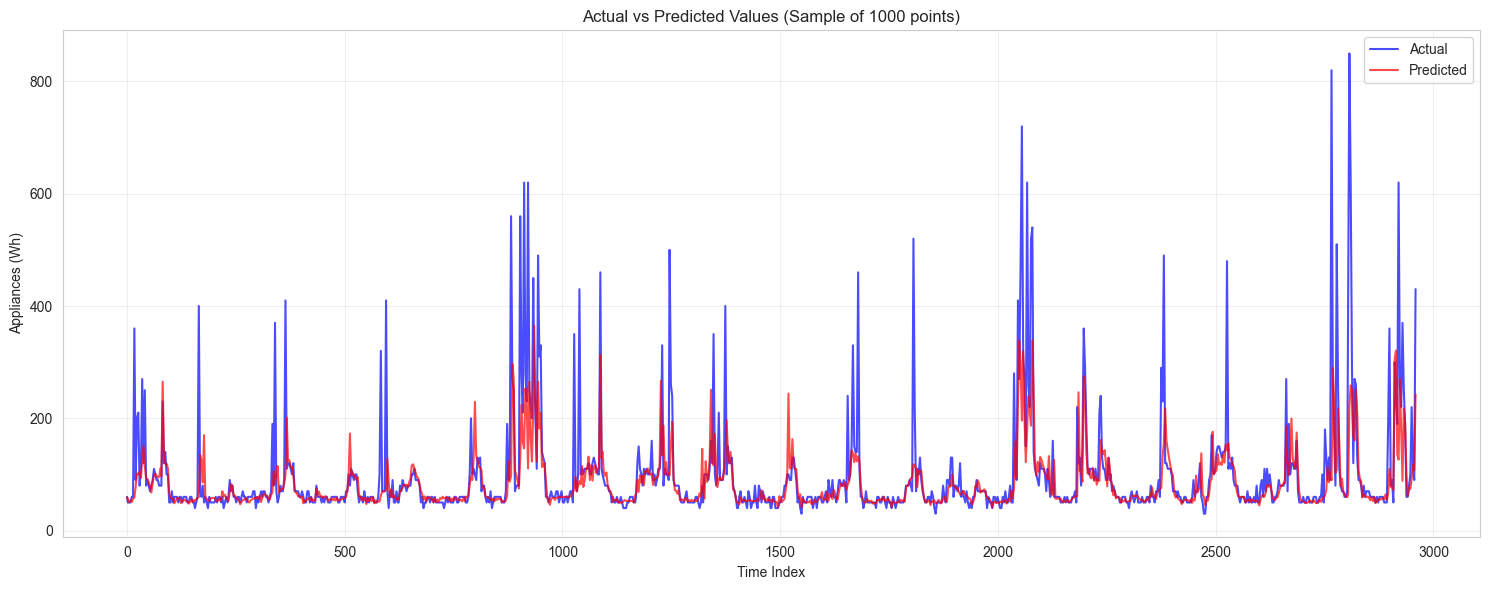

✓ Time series plot saved


In [15]:
n_plot = min(1000, len(y_true))
indices = np.linspace(0, len(y_true)-1, n_plot, dtype=int)

plt.figure(figsize=(15, 6))
plt.plot(indices, y_true[indices], label='Actual', alpha=0.7, linewidth=1.5, color='blue')
plt.plot(indices, y_pred_final[indices], label='Predicted', alpha=0.7, linewidth=1.5, color='red')
plt.xlabel('Time Index')
plt.ylabel('Appliances (Wh)')
plt.title(f'Actual vs Predicted Values (Sample of {n_plot} points)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('models/timeseries_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Time series plot saved")


## 11. Visualization 2: Scatter Plot
###### Correlation between actual and predicted values

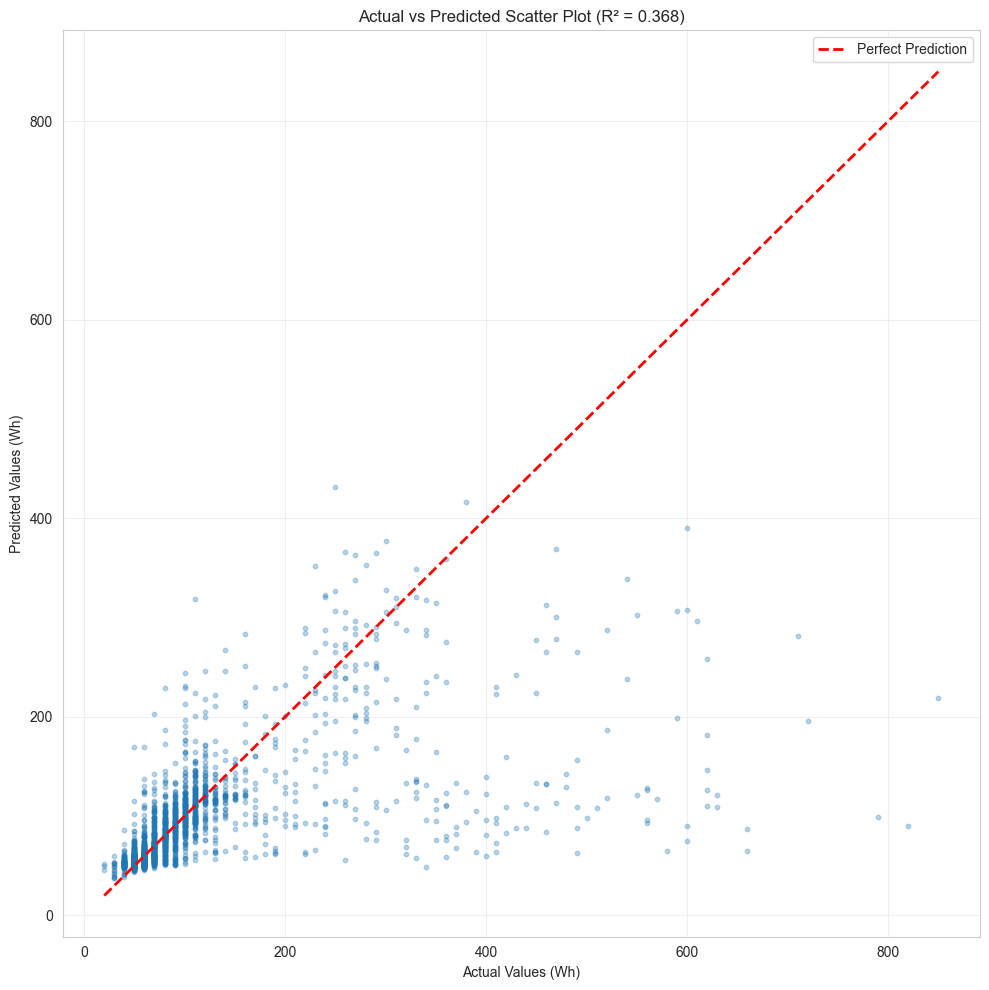

✓ Scatter plot saved


In [16]:
plt.figure(figsize=(10, 10))

# Sample for clarity if dataset is large
if len(y_true) > 5000:
    sample_idx = np.random.choice(len(y_true), 5000, replace=False)
    y_true_plot = y_true[sample_idx]
    y_pred_plot = y_pred_final[sample_idx]
else:
    y_true_plot = y_true
    y_pred_plot = y_pred_final

plt.scatter(y_true_plot, y_pred_plot, alpha=0.3, s=10)
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 
         'r--', lw=2, label='Perfect Prediction')
plt.xlabel('Actual Values (Wh)')
plt.ylabel('Predicted Values (Wh)')
plt.title(f'Actual vs Predicted Scatter Plot (R² = {metrics_final["R2"]:.3f})')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('models/scatter_plot.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Scatter plot saved")


## 12. Generate Evaluation Report

In [17]:
report = {
    'model_info': {
        'model_type': metadata['model_type'],
        'training_date': metadata['training_date'],
        'n_features': metadata['n_features'],
        'best_iteration': metadata['best_iteration']
    },
    'dataset_info': {
        'n_train': metadata['n_train_samples'],
        'n_val': metadata['n_val_samples'],
        'n_test': metadata['n_test_samples']
    },
    'performance_metrics': {
        'mae': float(metrics_final['MAE']),
        'rmse': float(metrics_final['RMSE']),
        'r2': float(metrics_final['R2']),
        'mape': float(metrics_final['MAPE'])
    },
    'error_statistics': {
        'mean_error': float(errors.mean()),
        'median_error': float(np.median(errors)),
        'std_error': float(errors.std()),
        'max_error': float(errors.max()),
        'p95_error': float(np.percentile(errors, 95))
    },
    'accuracy_by_tolerance': {
        f'within_{int(row.tolerance)}': float(row.percentage)
        for row in accuracy_df.itertuples()
    },
    'performance_by_usage': usage_analysis.to_dict('records'),
    'smoothing_impact': {
        'raw_mae': float(metrics_raw['MAE']),
        'smoothed_mae': float(metrics_smoothed['MAE']),
        'improvement': float(metrics_raw['MAE'] - metrics_smoothed['MAE'])
    }
}

# Save report
report_path = 'models/evaluation_report.json'
import os
os.makedirs('models/evaluation', exist_ok=True)
with open(report_path, 'w') as f:
    json.dump(report, f, indent=2)

print(f"✓ Evaluation report saved to: {report_path}")


✓ Evaluation report saved to: models/evaluation_report.json


## 13. Final Summary


In [18]:
print("\n" + "="*80)
print("EVALUATION COMPLETE - FINAL SUMMARY")
print("="*80)

print(f"\n{'METRIC':<20} {'VALUE'}")
print("-" * 50)
print(f"{'MAE':<20} {metrics_final['MAE']:.2f} Wh")
print(f"{'RMSE':<20} {metrics_final['RMSE']:.2f} Wh")
print(f"{'R² Score':<20} {metrics_final['R2']:.4f}")
print(f"{'MAPE':<20} {metrics_final['MAPE']:.2f}%")

print(f"\n{'ACCURACY':<20} {'VALUE'}")
print("-" * 50)
print(f"{'Within ±10 Wh':<20} {accuracy_df[accuracy_df['tolerance']==10]['percentage'].values[0]:.1f}%")
print(f"{'Within ±20 Wh':<20} {accuracy_df[accuracy_df['tolerance']==20]['percentage'].values[0]:.1f}%")
print(f"{'Within ±50 Wh':<20} {accuracy_df[accuracy_df['tolerance']==50]['percentage'].values[0]:.1f}%")

print(f"\n{'ERROR STATS':<20} {'VALUE'}")
print("-" * 50)
print(f"{'Mean Error':<20} {errors.mean():.2f} Wh")
print(f"{'Median Error':<20} {np.median(errors):.2f} Wh")
print(f"{'95th Percentile':<20} {np.percentile(errors, 95):.2f} Wh")



print("\n" + "="*80)
print("✓ All evaluation complete! Check models/evaluation/ for outputs")
print("="*80)


EVALUATION COMPLETE - FINAL SUMMARY

METRIC               VALUE
--------------------------------------------------
MAE                  26.93 Wh
RMSE                 72.25 Wh
R² Score             0.3681
MAPE                 18.68%

ACCURACY             VALUE
--------------------------------------------------
Within ±10 Wh        57.5%
Within ±20 Wh        77.8%
Within ±50 Wh        90.1%

ERROR STATS          VALUE
--------------------------------------------------
Mean Error           26.93 Wh
Median Error         8.18 Wh
95th Percentile      122.05 Wh

✓ All evaluation complete! Check models/evaluation/ for outputs
